# RNN

Recurrent neural networks use sequential data to solve common temporal problems seen in language translation and speech recognition.

Why RNNs?
- Possibility of processing input of any length
- Model size not increasing with size of input
- Computation takes into account historical information
- Weights are shared across time

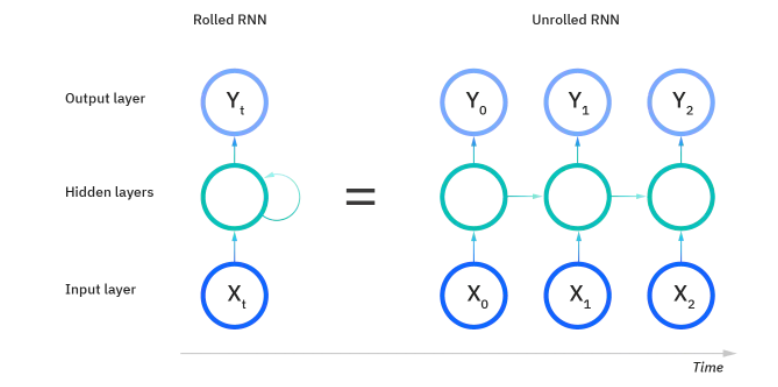

There are many types of RNNs. We'll be touching upon RNN, LSTM and GRU

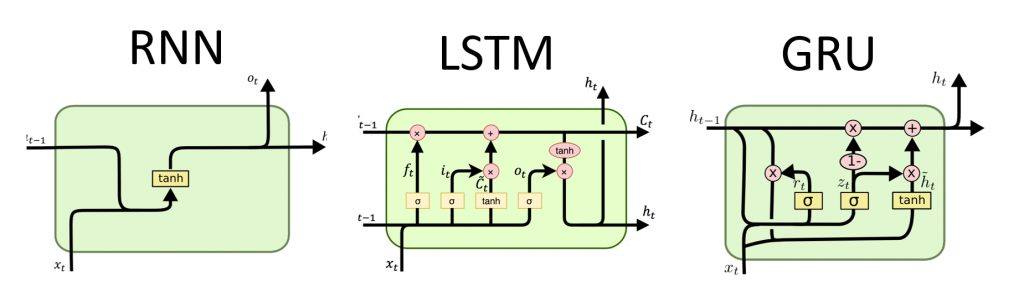

Downloading IMDB classification dataset



In [ ]:
!gdown 1o5Hu9mOZsXxhIbPEov80LsxxCs5A2_7W -O './imdb.csv'

Downloading...
From: https://drive.google.com/uc?id=1o5Hu9mOZsXxhIbPEov80LsxxCs5A2_7W
To: /content/imdb.csv
100% 66.2M/66.2M [00:00<00:00, 74.2MB/s]


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("imdb.csv", usecols=["review", "sentiment"], encoding='latin-1')
## 1 - positive, 0 - negative
df.sentiment = (df.sentiment == "positive").astype("int")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)


def train_val_test_split(df=None, train_percent=0.7, test_percent=0.15, val_percent=0.15):
  df = df.sample(frac=1)
  train_df = df[: int(len(df)*train_percent)]
  test_df = df[int(len(df)*train_percent)+1 : int(len(df)*(train_percent+test_percent))]
  val_df = df[int(len(df)*(train_percent + test_percent))+1 : ]
  return train_df, test_df, val_df

train_df, test_df, val_df = train_val_test_split(df, 0.7, 0.15, 0.15)
train_labels, train_texts = train_df.values[:,1], train_df.values[:,0]
val_labels, val_texts = val_df.values[:,1], val_df.values[:,0]
test_labels, test_texts = test_df.values[:,1], test_df.values[:,0]
print(len(train_df), len(test_df), len(val_df))
print(len(train_texts), len(train_labels), len(val_df))

35000 7499 7499
35000 35000 7499


In [ ]:
train_texts[:5]

array(['This was a very enjoyable film. A humorous, but poignant look at family, and the obligations that come with it. The story of a man who comes home from his life in the city to his fathers bath house in a small Chinese village. There he learns to appreciate, even cherish the very things he left home to get away from. The film is as visually beautiful as it is emotionally beautiful.',
       'My friend recommended this movie to me.Is should have known not to watch it because my friend is kind of a video game nerd. But the name and the cover made it look good for some reason. I was so wrong. I mean first of all, what is up with their suits? And the acting! It seems like they got the people off Barney. Except for Ben Kingsley. And why was he even in this movie? Did he think it was a comedy! But I have to say the special effects were pretty good. But that was like the only good thing in it. I mean seriously, the movie is worse than Pearl Harbor. And thats actually an understatement. 

### Tokenization

We convert each sentence of our dataset to tokens. This leads to easier preprocessing, since we need to convert our words into numbers, that the ML model understands

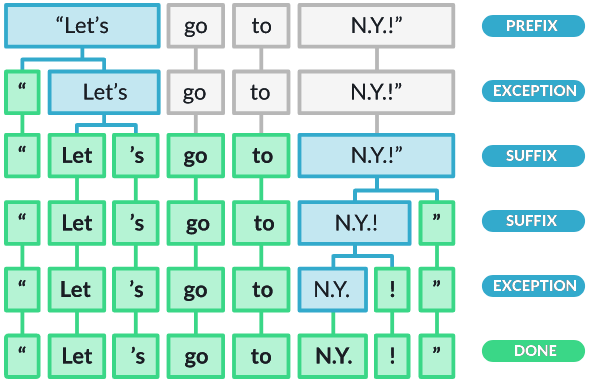

In [ ]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

def process_tokens(text):
    """
    function to process tokens, replace any unwanted chars
    """
    preprocessed_text = text.lower().replace(",", "").replace(".", "").replace(":", "").replace(")", "").replace("-", "").replace("(", "")
    preprocessed_text = ''.join([i for i in preprocessed_text if not preprocessed_text.isdigit()])
    return preprocessed_text

def preprocessing(data):
    """
    preprocessing data to list of tokens
    """
    nlp = English()
    tokenizer = Tokenizer(nlp.vocab)
    preprocessed_data = []
    for sentence in data:
        sentence = process_tokens(sentence)
        tokens = tokenizer(sentence)
        tlist = []
        for token in tokens:
            tlist.append(str(token))
        preprocessed_data.append(tlist)
    return preprocessed_data

train_data = preprocessing(train_texts)
val_data = preprocessing(val_texts)
test_data = preprocessing(test_texts)

In [ ]:
print(train_data[0])

['this', 'was', 'a', 'very', 'enjoyable', 'film', 'a', 'humorous', 'but', 'poignant', 'look', 'at', 'family', 'and', 'the', 'obligations', 'that', 'come', 'with', 'it', 'the', 'story', 'of', 'a', 'man', 'who', 'comes', 'home', 'from', 'his', 'life', 'in', 'the', 'city', 'to', 'his', 'fathers', 'bath', 'house', 'in', 'a', 'small', 'chinese', 'village', 'there', 'he', 'learns', 'to', 'appreciate', 'even', 'cherish', 'the', 'very', 'things', 'he', 'left', 'home', 'to', 'get', 'away', 'from', 'the', 'film', 'is', 'as', 'visually', 'beautiful', 'as', 'it', 'is', 'emotionally', 'beautiful']


### Bag of Words

There are a variety of ways to convert words to vectors. For this case, we opt to use the bag of words method to compute the vector representation of each sentence, wherein we're interested in the frequency of each word.

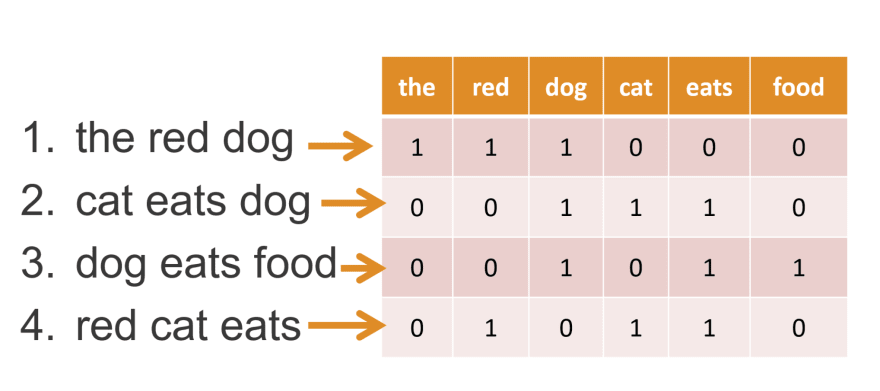

In [ ]:
import numpy as np
import itertools

## Creating a vectorizer to vectorize text and create matrix of features
## Bag of words technique
class Vectorizer():
    def __init__(self, max_features):
        self.max_features = max_features
        self.vocab_list = None
        self.token_to_index = None

    def fit(self, dataset):
        word_dict = {}
        for sentence in dataset:
            for token in sentence:
                if token not in word_dict:
                    word_dict[token] = 1
                else:
                    word_dict[token] += 1
        word_dict = dict(sorted(word_dict.items(), key=lambda item: item[1], reverse=True))
        end_to_slice = min(len(word_dict), self.max_features)
        word_dict = dict(itertools.islice(word_dict.items(), end_to_slice))
        self.vocab_list = list(word_dict.keys())
        self.token_to_index = {}
        counter = 0
        for token in self.vocab_list:
            self.token_to_index[token] = counter
            counter += 1


    def transform(self, dataset):
        data_matrix = np.zeros((len(dataset), len(self.vocab_list)))
        for i, sentence in enumerate(dataset):
            for token in sentence:
                if token in self.token_to_index:
                    data_matrix[i, self.token_to_index[token]] += 1
        return data_matrix

## max features - top k words to consider only
max_features = 2000

vectorizer = Vectorizer(max_features=max_features)
vectorizer.fit(train_data)

## Checking if the len of vocab = k
X_train = vectorizer.transform(train_data)
X_val = vectorizer.transform(val_data)
X_test = vectorizer.transform(test_data)

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

vocab = vectorizer.vocab_list

In [ ]:
## each sequence of token is a vector of
## token indices (with the count of those words)
X_train[:5]

array([[ 5.,  4.,  1., ...,  0.,  0.,  0.],
       [10.,  2.,  6., ...,  0.,  0.,  0.],
       [ 3.,  4.,  4., ...,  0.,  0.,  0.],
       [20., 10., 14., ...,  0.,  0.,  0.],
       [ 8.,  4.,  4., ...,  0.,  0.,  0.]])

In [ ]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_val = to_categorical(y_val, 2)

In [ ]:
X_train = X_train.reshape(-1, 1, X_train.shape[1])
X_val = X_val.reshape(-1, 1, X_val.shape[1])
X_test = X_test.reshape(-1, 1, X_test.shape[1])

y_train = y_train.reshape(-1, 2)
y_val = y_val.reshape(-1, 2)
y_test = y_test.reshape(-1, 2)

print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')

X_train.shape: (35000, 1, 2000), y_train.shape: (35000, 2)


### RNN model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam

model = None
model = Sequential()
model.add(SimpleRNN(128, input_shape=(1, max_features)))
model.add(Dense(2, activation='softmax'))

optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train,
          batch_size=256,
          validation_data=(X_val, y_val),
          epochs=2)
print(history.history.keys())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 128)               272512    
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 272,770
Trainable params: 272,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
137/137 [==============================] - 3s 12ms/step - loss: 0.3612 - accuracy: 0.8390 - val_loss: 0.3068 - val_accuracy: 0.8693
Epoch 2/2
137/137 [==============================] - 2s 11ms/step - loss: 0.2701 - accuracy: 0.8881 - val_loss: 0.2916 - val_accuracy: 0.8817
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
score, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)
print('Test accuracy:', acc)

Test loss: 0.29183512926101685
Test accuracy: 0.8758501410484314


### Exercise 1

In [ ]:
!wget "https://docs.google.com/spreadsheets/d/1CWYkFRKsVGUohERSqoD-w3mlgMHv6JPq3VW32ZYgtSs/export?format=csv" -O tweets.csv

--2023-04-07 03:07:52--  https://docs.google.com/spreadsheets/d/1CWYkFRKsVGUohERSqoD-w3mlgMHv6JPq3VW32ZYgtSs/export?format=csv
Resolving docs.google.com (docs.google.com)... 108.177.126.100, 108.177.126.113, 108.177.126.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.100|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-00-9s-sheets.googleusercontent.com/export/r6backulg5lnalo18mkmp7tf28/n4lfo5oseea3upjn4clp5ijmb4/1680836870000/104703212548280305851/*/1CWYkFRKsVGUohERSqoD-w3mlgMHv6JPq3VW32ZYgtSs?format=csv [following]
--2023-04-07 03:07:53--  https://doc-00-9s-sheets.googleusercontent.com/export/r6backulg5lnalo18mkmp7tf28/n4lfo5oseea3upjn4clp5ijmb4/1680836870000/104703212548280305851/*/1CWYkFRKsVGUohERSqoD-w3mlgMHv6JPq3VW32ZYgtSs?format=csv
Resolving doc-00-9s-sheets.googleusercontent.com (doc-00-9s-sheets.googleusercontent.com)... 142.251.31.132, 2a00:1450:4013:c1a::84
Connecting to doc-00-9s-sheets.googleuserc

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import re

In [ ]:
data = pd.read_csv('tweets.csv')
# Keeping only the neccessary columns
data = data[['text','airline_sentiment']]

In [ ]:
data = data[data.airline_sentiment != "neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['airline_sentiment'] == 'positive'].size)
print(data[ data['airline_sentiment'] == 'negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

4726
18356


In [ ]:
Y = pd.get_dummies(data['airline_sentiment']).values
X_train_tweets, X_test_tweets, Y_train_tweets, Y_test_tweets = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train_tweets.shape,Y_train_tweets.shape)
print(X_test_tweets.shape,Y_test_tweets.shape)

(7732, 32) (7732, 2)
(3809, 32) (3809, 2)


In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))

# Add Simple RNN Layer
# Add Dense Layer

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 128)           256000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 2)                 258       
                                                                 
Total params: 289,154
Trainable params: 289,154
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# call model.fit for epochs = 7 and batch size = 256

Epoch 1/7
31/31 [==============================] - 3s 40ms/step - loss: 0.4616 - accuracy: 0.7929
Epoch 2/7
31/31 [==============================] - 1s 39ms/step - loss: 0.3026 - accuracy: 0.8762
Epoch 3/7
31/31 [==============================] - 1s 40ms/step - loss: 0.1478 - accuracy: 0.9454
Epoch 4/7
31/31 [==============================] - 1s 40ms/step - loss: 0.0806 - accuracy: 0.9758
Epoch 5/7
31/31 [==============================] - 1s 40ms/step - loss: 0.0440 - accuracy: 0.9889
Epoch 6/7
31/31 [==============================] - 1s 41ms/step - loss: 0.0272 - accuracy: 0.9937
Epoch 7/7
31/31 [==============================] - 1s 48ms/step - loss: 0.0208 - accuracy: 0.9951
dict_keys(['loss', 'accuracy'])


In [ ]:
# Print loss and accuracy on the test set

Test loss: 0.30220142006874084
Test accuracy: 0.9133630990982056


### LSTM model

RNNs face a vanishing/exploding gradient problem.
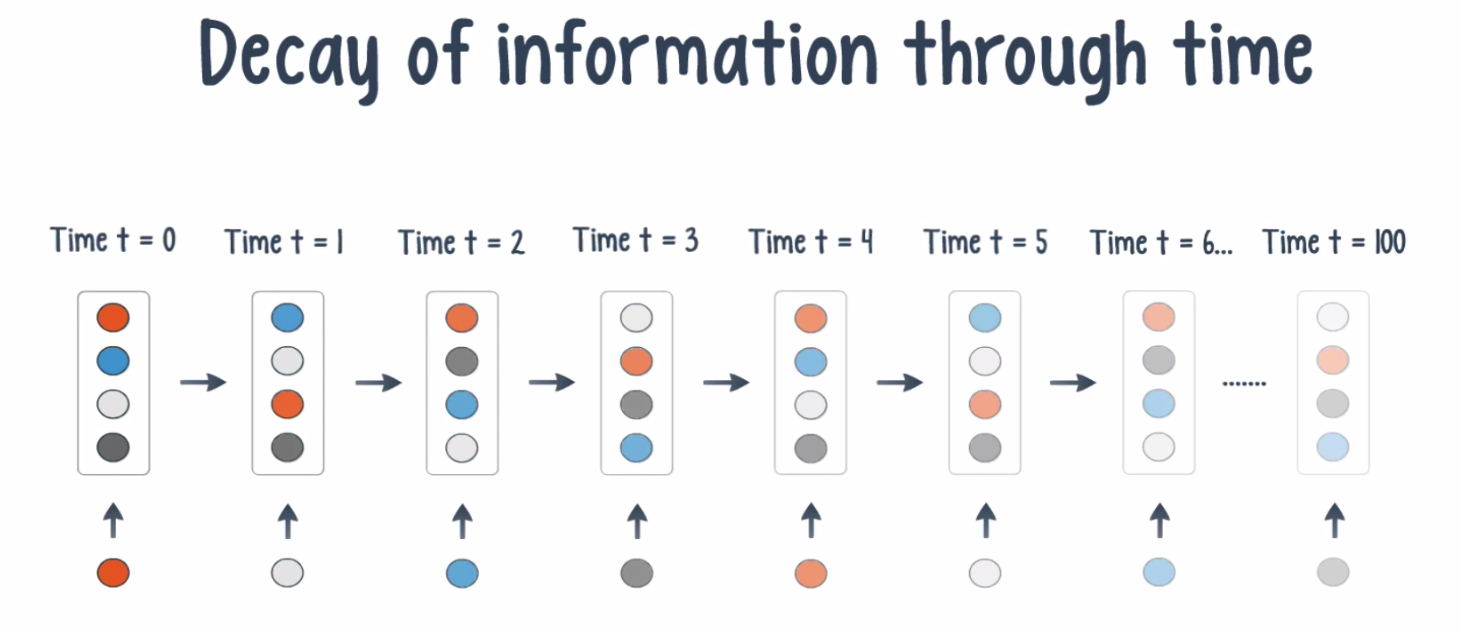


Long Short Term Memory (LSTM) builds upon RNN and takes care of the vanishing gradient problem as well. LSTM uses gates to filter out/add new information to the short term and long term memories.
- Input Gate - It decides what information will be stored in long term memory. It only works with the information from the current input and short term memory from the previous step. At this gate, it filters out the information from variables that are not useful.
- Forget Gate - It decides which information from long term memory be kept or discarded.
- Output Gate - It takes the current input, the previous short term memory and newly computed long term memory to produce new short term memory which will be passed on to the cell in the next time step.

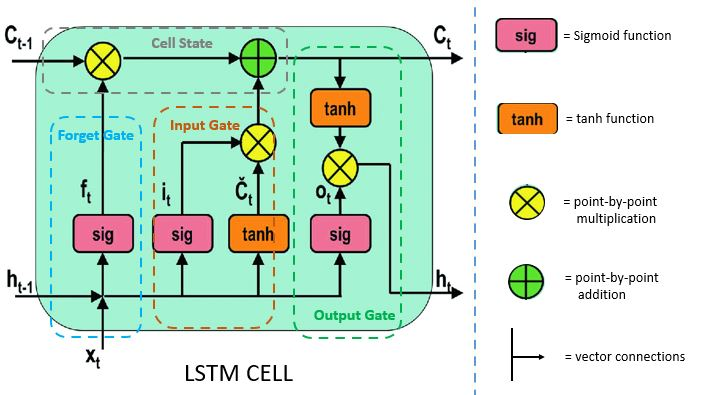

In [ ]:
from tensorflow.keras.layers import LSTM

model = None
model = Sequential()
model.add(LSTM(128, input_shape=(1, max_features)))
model.add(Dense(2, activation='softmax'))

optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train,
          batch_size=256,
          validation_data=(X_val, y_val),
          epochs=2)
print(history.history.keys())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               1090048   
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 1,090,306
Trainable params: 1,090,306
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
137/137 [==============================] - 7s 34ms/step - loss: 0.3686 - accuracy: 0.8422 - val_loss: 0.2892 - val_accuracy: 0.8793
Epoch 2/2
137/137 [==============================] - 4s 26ms/step - loss: 0.2574 - accuracy: 0.8960 - val_loss: 0.2840 - val_accuracy: 0.8831
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
score, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)
print('Test accuracy:', acc)

Test loss: 0.28718316555023193
Test accuracy: 0.8821176290512085


### Exercise 2

In [ ]:
!wget "https://docs.google.com/spreadsheets/d/1CWYkFRKsVGUohERSqoD-w3mlgMHv6JPq3VW32ZYgtSs/export?format=csv" -O tweets.csv

--2023-04-07 03:12:00--  https://docs.google.com/spreadsheets/d/1CWYkFRKsVGUohERSqoD-w3mlgMHv6JPq3VW32ZYgtSs/export?format=csv
Resolving docs.google.com (docs.google.com)... 108.177.126.113, 108.177.126.138, 108.177.126.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.113|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-00-9s-sheets.googleusercontent.com/export/r6backulg5lnalo18mkmp7tf28/fnbes1e1s9snnrdtv56rilc8e4/1680837120000/104703212548280305851/*/1CWYkFRKsVGUohERSqoD-w3mlgMHv6JPq3VW32ZYgtSs?format=csv [following]
--2023-04-07 03:12:00--  https://doc-00-9s-sheets.googleusercontent.com/export/r6backulg5lnalo18mkmp7tf28/fnbes1e1s9snnrdtv56rilc8e4/1680837120000/104703212548280305851/*/1CWYkFRKsVGUohERSqoD-w3mlgMHv6JPq3VW32ZYgtSs?format=csv
Resolving doc-00-9s-sheets.googleusercontent.com (doc-00-9s-sheets.googleusercontent.com)... 142.251.31.132, 2a00:1450:4013:c1a::84
Connecting to doc-00-9s-sheets.googleuserc

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import re

In [ ]:
data = pd.read_csv('tweets.csv')
# Keeping only the neccessary columns
data = data[['text','airline_sentiment']]

In [ ]:
data = data[data.airline_sentiment != "neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['airline_sentiment'] == 'positive'].size)
print(data[ data['airline_sentiment'] == 'negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

4726
18356


In [ ]:
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7732, 32) (7732, 2)
(3809, 32) (3809, 2)


In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))

# Add LSTM Layer
# Add Dense Layer

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 32, 128)           256000    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_6 (Dense)             (None, 2)                 258       
                                                                 
Total params: 387,842
Trainable params: 387,842
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# call model.fit for epochs = 7 and batch size = 256

Epoch 1/7
31/31 [==============================] - 6s 116ms/step - loss: 0.4712 - accuracy: 0.8008
Epoch 2/7
31/31 [==============================] - 4s 134ms/step - loss: 0.2648 - accuracy: 0.8929
Epoch 3/7
31/31 [==============================] - 4s 116ms/step - loss: 0.1645 - accuracy: 0.9391
Epoch 4/7
31/31 [==============================] - 4s 121ms/step - loss: 0.1318 - accuracy: 0.9523
Epoch 5/7
31/31 [==============================] - 4s 141ms/step - loss: 0.1030 - accuracy: 0.9596
Epoch 6/7
31/31 [==============================] - 4s 131ms/step - loss: 0.0900 - accuracy: 0.9664
Epoch 7/7
31/31 [==============================] - 4s 117ms/step - loss: 0.0794 - accuracy: 0.9712
dict_keys(['loss', 'accuracy'])


In [ ]:
# Print loss and accuracy on the test set

Test loss: 0.27063825726509094
Test accuracy: 0.9165135025978088


### GRU

Gated Recurrent Unit (GRU)
- Update Gate - It's responsible for determining the amount of previous information that needs to pass along the next state.
- Reset Gate - The reset gate is used from the model to decide how much of the past information is needed to neglect; in short, it decides whether the previous cell state is important or not.

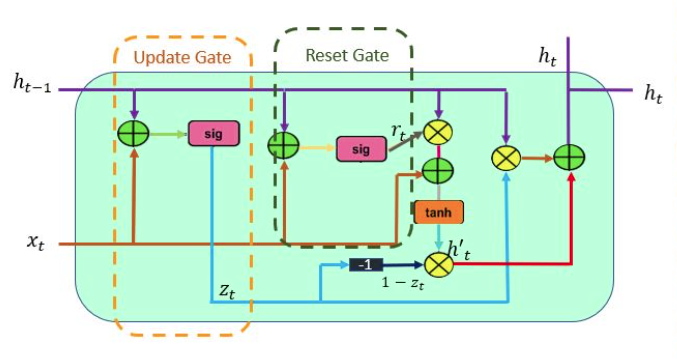

In [ ]:
# getting data ready
X_train = vectorizer.transform(train_data)
X_val = vectorizer.transform(val_data)
X_test = vectorizer.transform(test_data)

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [ ]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

In [ ]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_val = to_categorical(y_val, 2)

In [ ]:
X_train = X_train.reshape(-1, 1, X_train.shape[1])
X_val = X_val.reshape(-1, 1, X_val.shape[1])
X_test = X_test.reshape(-1, 1, X_test.shape[1])

y_train = y_train.reshape(-1, 2)
y_val = y_val.reshape(-1, 2)
y_test = y_test.reshape(-1, 2)

print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')

X_train.shape: (35000, 1, 2000), y_train.shape: (35000, 2)


In [ ]:
from tensorflow.keras.layers import GRU

model = None
model = Sequential()
model.add(GRU(128, input_shape=(1, max_features)))
model.add(Dense(2, activation='softmax'))

optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train,
          batch_size=256,
          validation_data=(X_val, y_val),
          epochs=2)
print(history.history.keys())

score, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)
print('Test accuracy:', acc)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 128)               817920    
                                                                 
 dense_8 (Dense)             (None, 2)                 258       
                                                                 
Total params: 818,178
Trainable params: 818,178
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
137/137 [==============================] - 5s 23ms/step - loss: 0.3582 - accuracy: 0.8444 - val_loss: 0.2886 - val_accuracy: 0.8811
Epoch 2/2
137/137 [==============================] - 3s 19ms/step - loss: 0.2604 - accuracy: 0.8933 - val_loss: 0.2853 - val_accuracy: 0.8848
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Test loss: 0.28919607400894165
Test accuracy: 0.8803840279579163


In [ ]:
# check predictions
from tensorflow.keras.backend import argmax

y_pred = model.predict(X_test)
for i in range(5):
  print(f'Label predicted: {argmax(y_pred[i]).numpy()}, Actual label: {argmax(y_test[i]).numpy()}')
  print(f'text: {test_texts[i]}')

235/235 [==============================] - 1s 3ms/step
Label predicted: 0, Actual label: 0
text: I must admit, there are few books with corresponding movies that I have actually read before seeing the cinematic adaptation. Nineteen Eighty-Four happens to be one of those rare cases. The book was great. It was immersive and interestingly prophetic. But the movie just plain sucked. It is easily the worst film I have ever seen. The only reason I didn't turn it off after the first 5 minutes was the fact that watching the movie was half of a two-part assignment for a class. It was dark and grotesque, but did nothing in the way of achieving the proper atmosphere. The acting was nothing above average, and considering the fact that there wasn't much to act out, this was severely disappointing. The book, for example, didn't give me the impression that Winston was unable to blurt out more than a single syllable at a time. Boring, disturbing, and visually unappealing, the movie totally cannibalize

### Exercise 3

In [ ]:
!wget "https://docs.google.com/spreadsheets/d/1CWYkFRKsVGUohERSqoD-w3mlgMHv6JPq3VW32ZYgtSs/export?format=csv" -O tweets.csv

--2023-04-07 03:18:08--  https://docs.google.com/spreadsheets/d/1CWYkFRKsVGUohERSqoD-w3mlgMHv6JPq3VW32ZYgtSs/export?format=csv
Resolving docs.google.com (docs.google.com)... 108.177.126.101, 108.177.126.139, 108.177.126.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.101|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-00-9s-sheets.googleusercontent.com/export/r6backulg5lnalo18mkmp7tf28/muscq37h0mcjgs4poio7vmgonc/1680837485000/104703212548280305851/*/1CWYkFRKsVGUohERSqoD-w3mlgMHv6JPq3VW32ZYgtSs?format=csv [following]
--2023-04-07 03:18:08--  https://doc-00-9s-sheets.googleusercontent.com/export/r6backulg5lnalo18mkmp7tf28/muscq37h0mcjgs4poio7vmgonc/1680837485000/104703212548280305851/*/1CWYkFRKsVGUohERSqoD-w3mlgMHv6JPq3VW32ZYgtSs?format=csv
Resolving doc-00-9s-sheets.googleusercontent.com (doc-00-9s-sheets.googleusercontent.com)... 142.251.31.132, 2a00:1450:4013:c1a::84
Connecting to doc-00-9s-sheets.googleuserc

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import re

In [ ]:
data = pd.read_csv('tweets.csv')
# Keeping only the neccessary columns
data = data[['text','airline_sentiment']]

In [ ]:
data = data[data.airline_sentiment != "neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['airline_sentiment'] == 'positive'].size)
print(data[ data['airline_sentiment'] == 'negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

<ipython-input-74-7c1668a3ce77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(lambda x: x.lower())
<ipython-input-74-7c1668a3ce77>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


4726
18356


In [ ]:
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7732, 32) (7732, 2)
(3809, 32) (3809, 2)


In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))

# Add GRU Layer
# Add Dense Layer

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 32, 128)           256000    
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dense_9 (Dense)             (None, 2)                 258       
                                                                 
Total params: 355,330
Trainable params: 355,330
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# call model.fit for epochs = 7 and batch size = 256

Epoch 1/7
31/31 [==============================] - 3s 102ms/step - loss: 0.2179 - accuracy: 0.9150
Epoch 2/7
31/31 [==============================] - 3s 94ms/step - loss: 0.1429 - accuracy: 0.9465
Epoch 3/7
31/31 [==============================] - 3s 93ms/step - loss: 0.1079 - accuracy: 0.9613
Epoch 4/7
31/31 [==============================] - 3s 97ms/step - loss: 0.0949 - accuracy: 0.9642
Epoch 5/7
31/31 [==============================] - 3s 103ms/step - loss: 0.0787 - accuracy: 0.9728
Epoch 6/7
31/31 [==============================] - 3s 92ms/step - loss: 0.0629 - accuracy: 0.9781
Epoch 7/7
31/31 [==============================] - 3s 93ms/step - loss: 0.0547 - accuracy: 0.9802
dict_keys(['loss', 'accuracy'])


In [ ]:
# Print loss and accuracy on the test set

Test loss: 0.3408876061439514
Test accuracy: 0.9067996740341187


In [ ]:
# check predictions

120/120 [==============================] - 1s 8ms/step
Label predicted: 0, Actual label: 0
text: I must admit, there are few books with corresponding movies that I have actually read before seeing the cinematic adaptation. Nineteen Eighty-Four happens to be one of those rare cases. The book was great. It was immersive and interestingly prophetic. But the movie just plain sucked. It is easily the worst film I have ever seen. The only reason I didn't turn it off after the first 5 minutes was the fact that watching the movie was half of a two-part assignment for a class. It was dark and grotesque, but did nothing in the way of achieving the proper atmosphere. The acting was nothing above average, and considering the fact that there wasn't much to act out, this was severely disappointing. The book, for example, didn't give me the impression that Winston was unable to blurt out more than a single syllable at a time. Boring, disturbing, and visually unappealing, the movie totally cannibalize

# Sentiment Analysis using BERT

### Attention Model
Attention is proposed as a solution to the limitation of the Encoder-Decoder model which encodes the input sequence to one fixed length vector from which to decode the output at each time step. This issue is believed to a problem when decoding long sequences because it make difficult for the neural network to cope with long sentences, especially those that are longer than the sentences in the training corpus.


\

Goal: Identify and attend to the most important features in the input.

1. Encode the position information

2. Extract query, key and value for search.

3. Compute attention weighting

4. Extract features with high attention.

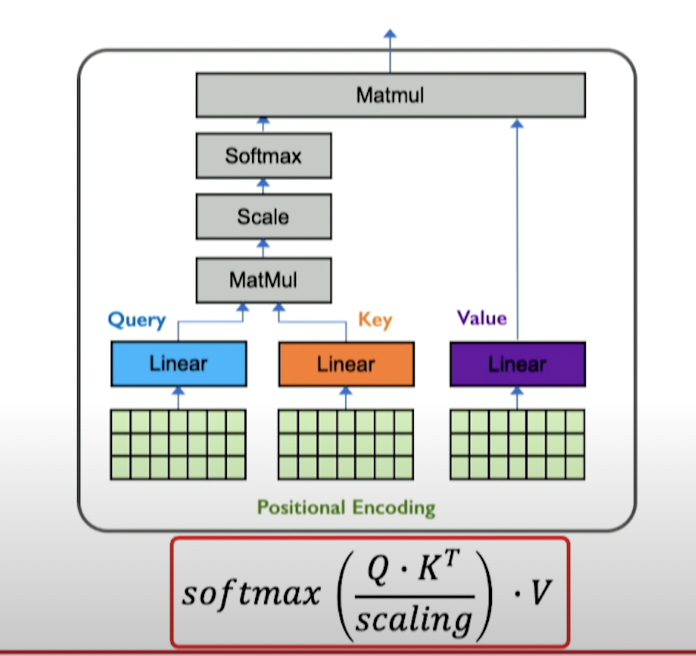

## BERT

As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the BERT Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).
\
\
a) Masked Language Model

BERT learns on the task "learn the word in a sentence in which 15% of the words are masked out". The masking is a form of regularization; it withholds just enough at preventing the algorithm from cheating through rote memorization.
\
\
b) Next Sentence Prediction

 BERT also receives training on a "is this sentence likely to follow this other one?" task. For this training task the sentence input is formatted like so: [CLS] ...sentence1 [SEP] ...sentence2 [SEP]. The output result is softmax on the first input value to the model.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

(ds_train, ds_test), ds_info = tfds.load('imdb_reviews',
          split = (tfds.Split.TRAIN, tfds.Split.TEST),
          as_supervised=True,
          with_info=True)


from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


def convert_example_to_feature(review):
  return tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

# can be up to 512 for BERT
max_length = 512
batch_size = 8

def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds, limit=-1):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  if (limit > 0):
      ds = ds.take(limit)
  for review, label in tfds.as_numpy(ds):
    bert_input = convert_example_to_feature(review.decode())
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)



# train dataset
ds_train_encoded = encode_examples(ds_train).shuffle(10000).batch(batch_size)
# test dataset
ds_test_encoded = encode_examples(ds_test).batch(batch_size)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteM4URQS/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteM4URQS/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteM4URQS/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 1 epoch, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 1
# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')


# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded)


3125/3125 [==============================] - 2596s 817ms/step - loss: 0.2419 - accuracy: 0.9026 - val_loss: 0.1652 - val_accuracy: 0.9378


In [ ]:
test_sentence = "This is a really good movie. I loved it and will watch again"

predict_input = tokenizer.encode(test_sentence,truncation=True,padding=True,return_tensors="tf")

tf_output = model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Negative','Positive'] #(0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])

Positive


Pytorch: https://github.com/vonsovsky/bert-sentiment/blob/master/notebooks/Sentiment_classifier.ipynb

## References:

https://www.analyticsvidhya.com/blog/2021/12/fine-tune-bert-model-for-sentiment-analysis-in-google-colab/





# Text Generation Using GPT

Generative Pre-trained Transformer (GPT) models can perform various NLP tasks like question answering, textual entailment, text summarisation etc. without any supervised training. These language models need very few to no examples to understand the tasks and perform equivalent or even better than the state-of-the-art models trained in supervised fashion.
\
\
This semi-supervised learning (unsupervised pre-training followed by supervised fine-tuning) for NLP tasks has following two components:

\

a. Unsupervised Learning: This part aimed at predicting the next word or token, given a set of previous tokens.


b. Supervised Fine-Tuning: This part aimed at maximising the likelihood of observing label y, given features or tokens x_1,…,x_n.


Instead of simply maximising the objective mentioned, the authors added an auxiliary learning objective for supervised fine-tuning to get better generalisation and faster convergence. The modified training objective was stated as:

        L(C) = L1(C) + λ L2(C)
where L1(C) was the auxiliary objective of learning language model and λ was the weight given to this secondary learning objective. λ was set to 0.5.


In [ ]:
from transformers import GPT2LMHeadModel , GPT2Tokenizer

#Load Model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
model = GPT2LMHeadModel.from_pretrained('gpt2-large' , pad_token_id = tokenizer.eos_token_id )
tokenizer.decode(tokenizer.eos_token_id)


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02G [00:00<?, ?B/s]

'<|endoftext|>'

In [ ]:

#Tokenize the text
sentence = "This is a deep learning class."
input_ids = tokenizer.encode(sentence , return_tensors = 'pt')
print(input_ids)
print(tokenizer.decode(input_ids[0][0]))
print(tokenizer.decode(input_ids[0][1]))

tensor([[1212,  318,  257, 2769, 4673, 1398,   13]])
This
 is


In [ ]:
#Generate and Decode Text
output = model.generate(input_ids, max_length = 500, num_beams = 5,no_repeat_ngram_size  = 5 , early_stopping = True)
output[0]


tensor([ 1212,   318,   257,  2769,  4673,  1398,    13,   921,   481,  2193,
          703,   284,   779,  2769,  4673,   284,  8494,  1103,    12,  6894,
         2761,    13,   921,   481,   635,  2193,   703,   284,  4174,  2769,
         4673,   284,   257,  4996,   286,  1103,    12,  6894,  2761,    11,
          884,   355,  2939,  9465,    11,  4046,  9465,    11,   290,  3288,
         3303,  7587,    13,   198,   198,  1212,  1781,   318,  3562,   329,
         2444,   508,   389,  4609,   287, 11524,  2769,  4673,   284,   257,
         3094,  2837,   286,  1103,    12,  6894,  5479,    11,  1390,  2939,
         9465,    11,  3288,  3303,  7587,    11,  4046,  9465,    11,  3288,
         3303, 11059,    11,   290,  4572,  4673,    13,   198,   198,  1212,
         1398,   318,  3562,   329,  2444,  4609,   287, 11524,  4572,  4673,
          284,   257,  3094,  4996,   286,  2761,    11,   884,   355,  3288,
         3303, 11059,    11,  4572,  4673,    11,  2939,  9465, 

In [ ]:
print(tokenizer.decode(output[0] , skip_special_tokens = True))

This is a deep learning class. You will learn how to use deep learning to solve real-world problems. You will also learn how to apply deep learning to a variety of real-world problems, such as image recognition, speech recognition, and natural language processing.

This course is designed for students who are interested in applying deep learning to a wide range of real-world applications, including image recognition, natural language processing, speech recognition, natural language translation, and machine learning.

This class is designed for students interested in applying machine learning to a wide variety of problems, such as natural language translation, machine learning, image recognition, and speech recognition.

This is an introductory course in machine learning. You will learn the fundamentals of machine learning and how to apply it to real-world problems in a variety of domains. You will also gain a deeper understanding of how machine learning works and how it can be applied 